In [1]:
import ast 
import pandas as pd 
from tqdm import tqdm 
import time 
from google.api_core import exceptions as google_exceptions 
import google.generativeai as genai 
import matplotlib.pyplot as plt 
import random

In [2]:
test_df = pd.read_csv('/kaggle/input/fpt-ai-residency-batch-6-entry-test/b6_test_data.csv')
test_df.head(5)

,task_id,question,choices
0,k10171,Question: What will be output of the following...,"['10', '9', '8', 'Error']"
1,k10182,Question: Consider line 3. Identify the compil...,"['No compilation error', 'Only a lexical error..."
2,k10184,Question: Assume the conflicts part (a) of thi...,['Equal precedence and left associativity; exp...
3,k10206,Question: What will be output if you will exec...,"['2.00000', '4.00000', '6.00000', 'Compilation..."
4,k10215,Question: Select the output for code :\nstatic...,"['amish', 'ANKIT', 'harsh', 'Compile time error']"


In [3]:
def create_full_question(row):
    question = row['question']
    choices_str = row['choices']
    choices = ast.literal_eval(choices_str)
    
    formatted_choices = '\n'.join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices)])
    full_question = f"{question}\n{formatted_choices}" + "\nPlease only provide the correct answer as one of the options: A, B, C, or D."
    return full_question

test_df['full_question'] = test_df.apply(create_full_question, axis=1)
test_df.head(5)

,task_id,question,choices,full_question
0,k10171,Question: What will be output of the following...,"['10', '9', '8', 'Error']",Question: What will be output of the following...
1,k10182,Question: Consider line 3. Identify the compil...,"['No compilation error', 'Only a lexical error...",Question: Consider line 3. Identify the compil...
2,k10184,Question: Assume the conflicts part (a) of thi...,['Equal precedence and left associativity; exp...,Question: Assume the conflicts part (a) of thi...
3,k10206,Question: What will be output if you will exec...,"['2.00000', '4.00000', '6.00000', 'Compilation...",Question: What will be output if you will exec...
4,k10215,Question: Select the output for code :\nstatic...,"['amish', 'ANKIT', 'harsh', 'Compile time error']",Question: Select the output for code :\nstatic...


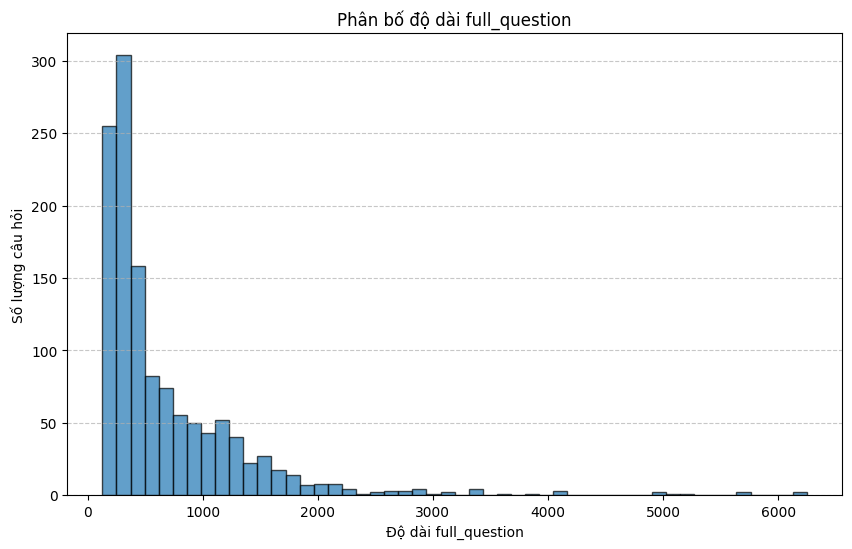

In [4]:
test_df["question_length"] = test_df["full_question"].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(test_df["question_length"], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Độ dài full_question")
plt.ylabel("Số lượng câu hỏi")
plt.title("Phân bố độ dài full_question")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [5]:
print(len(test_df))

1253


In [6]:
print(test_df.iloc[0]['full_question'])

Question: What will be output of the following c code?
#include<stdio.h>
int main()
{
    int a= sizeof(signed) +sizeof(unsigned);
    int b=sizeof(const)+sizeof(volatile);
    printf("%d",a+++b);
    return 0;
}
A. 10
B. 9
C. 8
D. Error
Please only provide the correct answer as one of the options: A, B, C, or D.


In [7]:
print(test_df.iloc[1]['full_question'])

Question: Consider line 3. Identify the compiler’s response about this line while creating the object-module
Int main()
{ int 1,N;
Fro (I,1 N,1);
}
A. No compilation error
B. Only a lexical error
C. Only syntactic errors
D. Both lexical and syntactic errors
Please only provide the correct answer as one of the options: A, B, C, or D.


In [ ]:
GOOGLE_API_KEY = ''

In [ ]:
genai.configure(api_key=GOOGLE_API_KEY)

models = genai.list_models()

for model in models:
    print(model.name, "-", model.description)


models/chat-bison-001 - A legacy text-only model optimized for chat conversations
models/text-bison-001 - A legacy model that understands text and generates text as an output
models/embedding-gecko-001 - Obtain a distributed representation of a text.
models/gemini-1.0-pro-vision-latest - The original Gemini 1.0 Pro Vision model version which was optimized for image understanding. Gemini 1.0 Pro Vision was deprecated on July 12, 2024. Move to a newer Gemini version.
models/gemini-pro-vision - The original Gemini 1.0 Pro Vision model version which was optimized for image understanding. Gemini 1.0 Pro Vision was deprecated on July 12, 2024. Move to a newer Gemini version.
models/gemini-1.5-pro-latest - Alias that points to the most recent production (non-experimental) release of Gemini 1.5 Pro, our mid-size multimodal model that supports up to 2 million tokens.
models/gemini-1.5-pro-001 - Stable version of Gemini 1.5 Pro, our mid-size multimodal model that supports up to 2 million tokens,

In [10]:
model = genai.GenerativeModel("gemini-2.0-flash")

In [11]:
response = model.generate_content(
"""
Question: What will be the output of the following C code?
#include<stdio.h>
const enum Alpha
{
      X,
      Y=5,
      Z
}p=10;
int main()
{
    enum Alpha a,b;
    a= X;
    b= Z;
    printf("%d",a+b-p); 
    return 0; 
}
A. -4
B. -5
C. 10
D. 11

Please only provide the correct answer as one of the options: A, B, C, or D.
"""
)

print(response.text)

B



In [12]:
def get_gemini_answers(questions):
    retry_delay = 60
    max_question_length = 4000  
    truncated_questions = [q[:max_question_length] for q in questions]  

    prompt = "\n\n".join([f"Question {i+1}:\n{q}" for i, q in enumerate(truncated_questions)])
    prompt += (
        "\n\nFor each question, respond with only the correct answer as a single letter: A, B, C, or D."
        " Do not provide any explanation, reasoning, or additional text."
        " Only return one letter per line corresponding to each question."
    )

    while True:
        try:
            response = model.generate_content(prompt)
            answers = response.text.strip().split("\n")
            
            valid_choices = {'A', 'B', 'C', 'D'}
            for i in range(len(answers)):
                if answers[i] not in valid_choices:
                    answers[i] = random.choice(['A', 'B', 'C', 'D'])

            return answers  

        except google_exceptions.ResourceExhausted:
            print(f"Quota exceeded. Retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)

In [13]:
def generate_answers(df, num_samples, batch_size, is_test=False):
    correct_count = 0
    gemini_answers = []
    
    for i in tqdm(range(0, num_samples, batch_size), desc="Processing Batches"):
        batch_df = df.iloc[i:i+batch_size]
        batch_questions = batch_df["full_question"].tolist()
        batch_answers = get_gemini_answers(batch_questions)
        
        if len(batch_answers) != len(batch_df):
            batch_answers = batch_answers[:len(batch_df)]  
        
        gemini_answers.extend(batch_answers)

        if not is_test:
            correct_count += sum(1 for pred, true in zip(batch_answers, batch_df["answer"]) if pred == true)

    if is_test:
        return gemini_answers, None
    else:
        accuracy = correct_count / num_samples * 100
        return gemini_answers, accuracy

In [14]:
num_samples = 1500 
test_df_subset = test_df.head(num_samples).copy()
gemini_answers, accuracy = generate_answers(test_df_subset, num_samples, 8, True)
test_df_subset["gemini_answer"] = gemini_answers

Processing Batches:   8%|▊         | 15/188 [00:06<01:11,  2.42it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  21%|██        | 39/188 [01:17<01:08,  2.19it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  29%|██▊       | 54/188 [02:24<01:18,  1.72it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  37%|███▋      | 69/188 [03:30<01:07,  1.75it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  45%|████▍     | 84/188 [04:37<00:59,  1.75it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  53%|█████▎    | 100/188 [05:44<00:43,  2.01it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  61%|██████    | 115/188 [06:50<00:38,  1.89it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  69%|██████▉   | 130/188 [07:57<00:28,  2.03it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  78%|███████▊  | 146/188 [09:03<00:20,  2.09it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  86%|████████▌ | 161/188 [10:09<00:12,  2.16it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  94%|█████████▍| 177/188 [11:14<00:04,  2.28it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches: 100%|██████████| 188/188 [12:18<00:00,  3.93s/it]


In [15]:
print(f"Accuracy: {accuracy}%")

Accuracy: None%


In [16]:
submission_df = test_df_subset[["task_id", "gemini_answer"]].rename(columns={"gemini_answer": "answer"})
submission_df.to_csv("submission.csv", index=False)
submission_df.head(5)

,task_id,answer
0,k10171,B
1,k10182,D
2,k10184,A
3,k10206,C
4,k10215,D


In [17]:
print(submission_df["answer"].value_counts())

answer
B    347
A    325
C    321
D    260
Name: count, dtype: int64
